In [1]:
print(__doc__)

import warnings

import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg

from sklearn.linear_model import (RandomizedLasso, lasso_stability_path, LassoLarsCV)
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, precision_recall_curve
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.utils.extmath import pinvh
from sklearn.exceptions import ConvergenceWarning


Automatically created module for IPython interactive environment


In [2]:
def mutual_incoherence(X_relevant, X_irelevant):
    projection = np.dot(np.dot(X_irelevant.T, X_relevant), pinvh(np.dot(X_relevant.T, X_relevant)))
    return np.max(np.abs(projection).sum(axis=1))

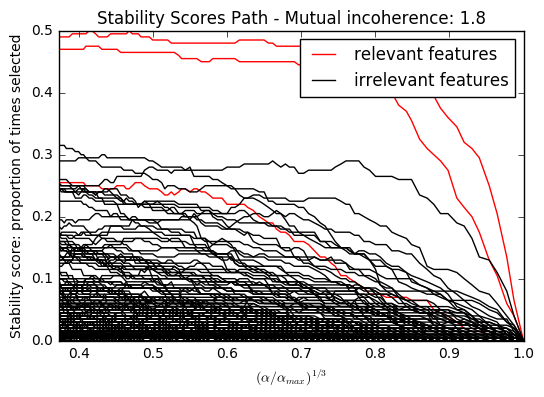

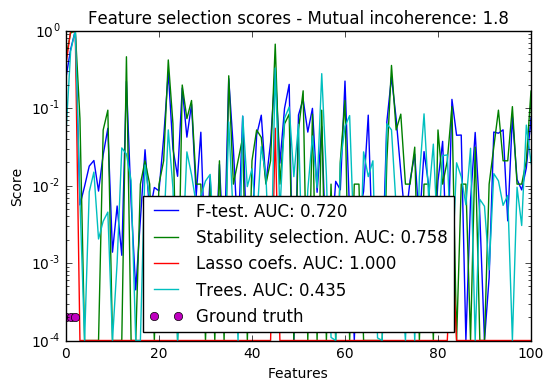

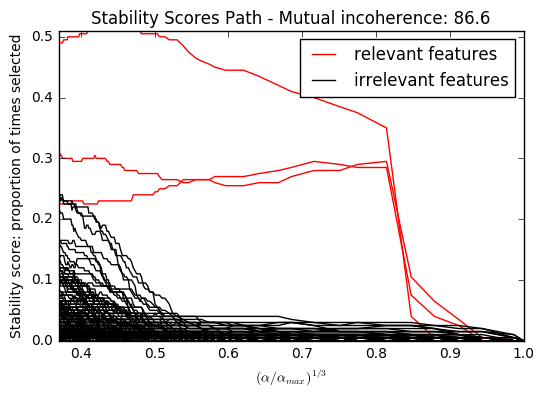

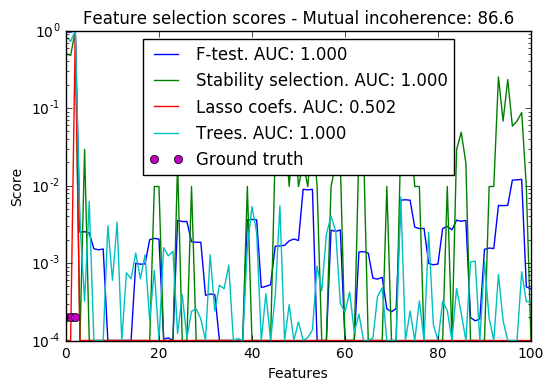

In [4]:
for conditioning in (1, 1e-4):
    n_features = 501
    n_relevant_features = 3
    noise_level = .2
    coef_min = .2
    
    n_samples = 25
    block_size = n_relevant_features
    
    rng = np.random.RandomState(42)
    
    coef = np.zeros(n_features)
    coef[:n_relevant_features] = coef_min + rng.rand(n_relevant_features)
    
    corr = np.zeros((n_features, n_features))
    for i in range(0, n_features, block_size):
        corr[i:i + block_size, i:i + block_size] = 1 - conditioning
    corr.flat[::n_features + 1] = 1
    corr = linalg.cholesky(corr)
    
    X = rng.normal(size=(n_samples, n_features))
    X = np.dot(X, corr)
    
    X[:n_relevant_features] /= np.abs(
        linalg.svdvals(X[:n_relevant_features])).max()
    X = StandardScaler().fit_transform(X.copy())

    # The output variable
    y = np.dot(X, coef)
    y /= np.std(y)
    # We scale the added noise as a function of the average correlation
    # between the design and the output variable
    y += noise_level * rng.normal(size=n_samples)
    mi = mutual_incoherence(X[:, :n_relevant_features],
                            X[:, n_relevant_features:])

    ###########################################################################
    # Plot stability selection path, using a high eps for early stopping
    # of the path, to save computation time
    alpha_grid, scores_path = lasso_stability_path(X, y, random_state=42,
                                                   eps=0.05)

    plt.figure()
    # We plot the path as a function of alpha/alpha_max to the power 1/3: the
    # power 1/3 scales the path less brutally than the log, and enables to
    # see the progression along the path
    hg = plt.plot(alpha_grid[1:] ** .333, scores_path[coef != 0].T[1:], 'r')
    hb = plt.plot(alpha_grid[1:] ** .333, scores_path[coef == 0].T[1:], 'k')
    ymin, ymax = plt.ylim()
    plt.xlabel(r'$(\alpha / \alpha_{max})^{1/3}$')
    plt.ylabel('Stability score: proportion of times selected')
    plt.title('Stability Scores Path - Mutual incoherence: %.1f' % mi)
    plt.axis('tight')
    plt.legend((hg[0], hb[0]), ('relevant features', 'irrelevant features'),
               loc='best')

    ###########################################################################
    # Plot the estimated stability scores for a given alpha

    # Use 6-fold cross-validation rather than the default 3-fold: it leads to
    # a better choice of alpha:
    # Stop the user warnings outputs- they are not necessary for the example
    # as it is specifically set up to be challenging.
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', UserWarning)
        warnings.simplefilter('ignore', ConvergenceWarning)
        lars_cv = LassoLarsCV(cv=6).fit(X, y)

    # Run the RandomizedLasso: we use a paths going down to .1*alpha_max
    # to avoid exploring the regime in which very noisy variables enter
    # the model
    alphas = np.linspace(lars_cv.alphas_[0], .1 * lars_cv.alphas_[0], 6)
    clf = RandomizedLasso(alpha=alphas, random_state=42).fit(X, y)
    trees = ExtraTreesRegressor(100).fit(X, y)
    # Compare with F-score
    F, _ = f_regression(X, y)

    plt.figure()
    for name, score in [('F-test', F),
                        ('Stability selection', clf.scores_),
                        ('Lasso coefs', np.abs(lars_cv.coef_)),
                        ('Trees', trees.feature_importances_),
                        ]:
        precision, recall, thresholds = precision_recall_curve(coef != 0,
                                                               score)
        plt.semilogy(np.maximum(score / np.max(score), 1e-4),
                     label="%s. AUC: %.3f" % (name, auc(recall, precision)))

    plt.plot(np.where(coef != 0)[0], [2e-4] * n_relevant_features, 'mo',
             label="Ground truth")
    plt.xlabel("Features")
    plt.ylabel("Score")
    # Plot only the 100 first coefficients
    plt.xlim(0, 100)
    plt.legend(loc='best')
    plt.title('Feature selection scores - Mutual incoherence: %.1f'
              % mi)

plt.show()
    